In [1]:
from utils.analysis_helpers import * 
from utils.plot_helpers import *
import numpy as np
import pandas as pd
import seaborn as sns
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## training and test performance

In [2]:
N_collection = [20, 40, 80]
V_factors = [1, 2, 4, 8]

performance = {'N': [], '|V|': [], 'factor': [], 
               'train_acc': [], 'test_acc': [], 
               'train_mae': [], 'test_mae': [], 'random_mae': []}

for N in N_collection:
    
    min_V = 2*N + 1
    
    for factor in V_factors: 
        
        V = min_V * factor
        
        interaction_train = load_interaction(N, V, mode='validation')
        interaction_test = load_interaction(N, V, mode='test')
        
        acc_train, mae_train = calc_performance(interaction_train)
        acc_test, mae_test = calc_performance(interaction_test)
        if factor == 1:
            random_mae = calc_random_mae(interaction_train)
        
        performance['N'].append(N)
        performance['|V|'].append(V)
        performance['factor'].append(factor)
        performance['train_acc'].append(acc_train.item())
        performance['train_mae'].append(mae_train.item())
        performance['test_acc'].append(acc_test.item())
        performance['test_mae'].append(mae_test.item())
        performance['random_mae'].append(random_mae.item())
        
performance = pd.DataFrame(performance)

In [3]:
performance

,N,|V|,factor,train_acc,test_acc,train_mae,test_mae,random_mae
0,20,41,1,0.851385,0.000000,0.931990,3.340909,11.857431
1,20,82,2,0.992443,0.022727,0.105793,1.590909,11.857431
2,20,164,4,1.000000,0.159091,0.000000,1.045455,11.857431
3,20,328,8,0.992443,0.068182,0.105793,1.386364,11.857431
4,40,81,1,0.815598,0.077381,1.537343,3.672619,23.453142
5,40,162,2,0.961005,0.214286,0.345010,2.327381,23.453142
6,40,324,4,0.994052,0.196429,0.031725,2.154762,23.453142
7,40,648,8,0.993391,0.273810,0.113020,2.125000,23.453142
8,80,161,1,0.569179,0.318598,7.223201,8.038110,46.766640
9,80,322,2,0.990178,0.879573,0.341914,0.414634,46.766640


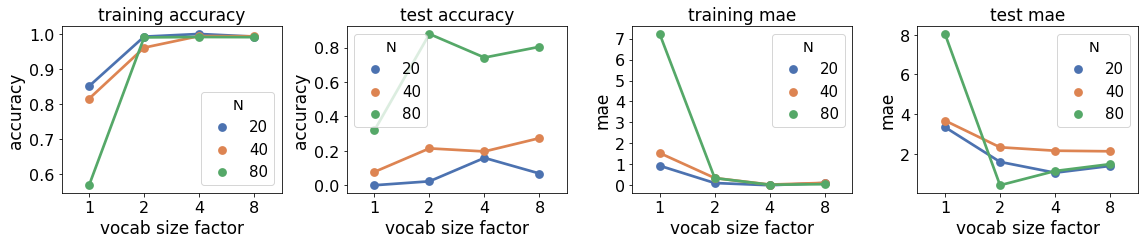

In [62]:
plt.figure(figsize=(16, 3.5))
for i in range(4):
    y = ['train_acc', 'test_acc', 'train_mae', 'test_mae'][i]
    plt.subplot(1, 4, i+1)
    ax = sns.pointplot(x='factor', hue='N', y=y, data=performance, alpha=0.5, palette='deep')
    plt.ylabel(['accuracy', 'accuracy', 'mae', 'mae'][i], fontsize=17)
    plt.xlabel('vocab size factor', fontsize=17)
    plt.title(['training accuracy', 'test accuracy', 'training mae', 'test mae'][i], fontsize=17)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    l = plt.legend(fontsize=15, title='N')
    l.get_title().set_fontsize(fontsize='x-large')
plt.tight_layout()

## performance relative to frequency

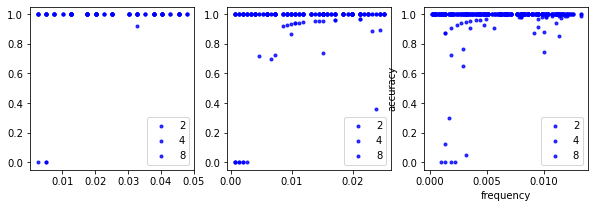

In [5]:
N_collection = [20, 40, 80]
V_factors = [2, 4, 8]
plt.figure(figsize=(10,3))

for i, N in enumerate(N_collection):
    
    plt.subplot(1,3,i+1)
    
    min_V = 2*N + 1
    
    for j, factor in enumerate(V_factors):
        
        color = ['blue', 'red', 'green'][j]
        V = min_V * factor
        
        logs = load_interaction(N, V, mode='validation')

        numbers = one_hot_to_numbers(logs.sender_input)
        receiver_output = torch.argmax(logs.receiver_output, dim=1)

        results = {'sum': [], 'frequency': [], 'accuracy': []}
        input_sums = torch.sum(numbers, dim=1)
        for sum_i in range(2*N+1):
            indices = torch.where(input_sums == sum_i)[0]
            if len(indices) > 0:
                results['sum'].append(sum_i)
                results['frequency'].append(len(indices) / len(input_sums))
                accuracy = torch.mean((input_sums[indices] == receiver_output[indices]).float())
                results['accuracy'].append(accuracy)
        plt.scatter(results['frequency'], results['accuracy'], color='blue', alpha=0.8, marker='.')
    
    plt.legend([2, 4, 8])
        
plt.xlabel('frequency')
plt.ylabel('accuracy')
plt.show()

## symbol use 

In [6]:
N_collection = [20, 40, 80]
V_factors = [1, 2, 4, 8]

symbol_use = {'N': [], '|V|': [], 'factor': [], 'absolute_use': [], 'relative_use': []}

for N in N_collection:
    
    min_V = 2*N + 1
    
    for factor in V_factors: 
        
        V = min_V * factor
        
        logs = load_interaction(N, V, mode='train')
        messages = logs.message.argmax(dim=-1)
        messages = np.ndarray.flatten(messages.numpy())
        distinct = set(messages)
        
        symbol_use['N'].append(N)
        symbol_use['|V|'].append(V)
        symbol_use['factor'].append(factor)
        symbol_use['absolute_use'].append(len(distinct))
        symbol_use['relative_use'].append(len(distinct) / V)
        
symbol_use = pd.DataFrame(symbol_use)

In [7]:
symbol_use

,N,|V|,factor,absolute_use,relative_use
0,20,41,1,39,0.951220
1,20,82,2,58,0.707317
2,20,164,4,86,0.524390
3,20,328,8,149,0.454268
4,40,81,1,79,0.975309
5,40,162,2,114,0.703704
6,40,324,4,132,0.407407
7,40,648,8,383,0.591049
8,80,161,1,144,0.894410
9,80,322,2,190,0.590062


## mapping between symbols and sums / input pairs 

In [35]:
N_collection = [20, 40, 80]
V_factors = [1, 2, 4, 8]

mappings = {'N': [], '|V|': [], 'factor': [], 'input_type': [], 'synonymy_mean': [], 'polysemy_mean': [], 
            'synonymy': [], 'polysemy': [], 'NMI': [], 'H(m|input)': [], 'H(input|m)': []}

for N in N_collection:
    print('loading results for N: ', N)
    
    min_V = 2*N + 1
    
    for factor in V_factors:
        
        V = min_V * factor
        
        logs = load_interaction(N, V, mode='train')
        numbers = one_hot_to_numbers(logs.sender_input)
        sums = torch.sum(numbers, dim=1)
        messages = logs.message.argmax(dim=-1)
        
        synonymy_summands, synonymy_summands_mean, _ = synonymy_dict(numbers, messages)
        synonymy_sum, synonymy_sum_mean, _ = synonymy_dict(sums, messages)
        polysemy_summands, polysemy_summands_mean, _ = polysemy_dict(numbers, messages)
        polysemy_sum, polysemy_sum_mean, _ = polysemy_dict(sums, messages)
        information_metrics = information_scores(logs)
        
        for input_type in ['sum', 'summands']:
            
            mappings['N'].append(N)
            mappings['|V|'].append(V)
            mappings['factor'].append(factor)
            mappings['input_type'].append(input_type)
            
            if input_type == 'sum':
                mappings['synonymy'].append(synonymy_sum)
                mappings['synonymy_mean'].append(synonymy_sum_mean)
                mappings['polysemy'].append(polysemy_sum)
                mappings['polysemy_mean'].append(polysemy_sum_mean)
                mappings['NMI'].append(information_metrics['NMI_sum'])
                mappings['H(m|input)'].append(information_metrics['synonymy_sum'])
                mappings['H(input|m)'].append(information_metrics['polysemy_sum'])
                
            elif input_type == 'summands':
                mappings['synonymy'].append(synonymy_summands)
                mappings['synonymy_mean'].append(synonymy_summands_mean)
                mappings['polysemy'].append(polysemy_summands)
                mappings['polysemy_mean'].append(polysemy_summands_mean)
                mappings['NMI'].append(information_metrics['NMI_summands'])
                mappings['H(m|input)'].append(information_metrics['synonymy_summands'])
                mappings['H(input|m)'].append(information_metrics['polysemy_summands'])

mappings = pd.DataFrame(mappings)

loading results for N:  20
loading results for N:  40
loading results for N:  80


In [9]:
mappings_subset = mappings.loc[:, (mappings.columns!='polysemy') & (mappings.columns!='synonymy')] 

In [10]:
mappings_subset[mappings.input_type=='summands']

,N,|V|,factor,input_type,synonymy_mean,polysemy_mean,NMI,H(m|input),H(input|m)
1,20,41,1,summands,1.267003,12.897436,0.720109,0.031817,0.426769
3,20,82,2,summands,1.259446,8.620690,0.752389,0.018093,0.390159
5,20,164,4,summands,2.224181,10.267442,0.720430,0.080089,0.407955
7,20,328,8,summands,2.952141,7.865772,0.720847,0.109445,0.394533
9,40,81,1,summands,1.313285,25.151899,0.703691,0.033764,0.446661
11,40,162,2,summands,1.107733,14.701754,0.740970,0.008198,0.408598
13,40,324,4,summands,1.190350,13.643939,0.747005,0.013784,0.398815
15,40,648,8,summands,3.296761,13.023499,0.711961,0.112861,0.405443
17,80,161,1,summands,1.655885,67.902778,0.645671,0.068062,0.506055
19,80,322,2,summands,1.128704,35.078947,0.719445,0.009930,0.434993


In [11]:
mappings_subset[mappings.input_type=='sum']

,N,|V|,factor,input_type,synonymy_mean,polysemy_mean,NMI,H(m|input),H(input|m)
0,20,41,1,sum,1.804878,1.897436,0.918140,0.082195,0.081524
2,20,82,2,sum,2.073171,1.465517,0.967456,0.055475,0.008472
4,20,164,4,sum,4.121951,1.965116,0.935185,0.102561,0.023754
6,20,328,8,sum,7.268293,2.000000,0.906208,0.152599,0.026215
8,40,81,1,sum,2.876543,2.949367,0.892906,0.105985,0.108202
10,40,162,2,sum,2.135802,1.517544,0.957035,0.060774,0.024468
12,40,324,4,sum,2.172840,1.333333,0.960533,0.067429,0.009778
14,40,648,8,sum,9.641975,2.039164,0.904216,0.160611,0.020106
16,80,161,1,sum,3.656250,4.062500,0.840521,0.133098,0.184301
18,80,322,2,sum,2.050000,1.726316,0.985236,0.021138,0.008306


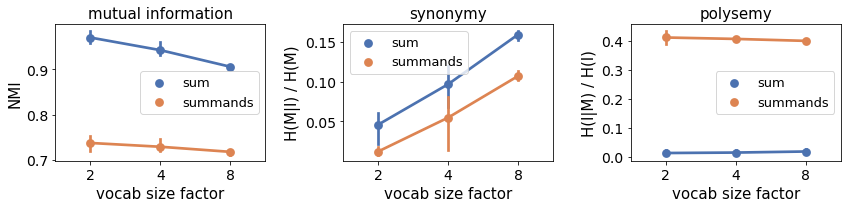

In [12]:
plt.figure(figsize=(12, 3))

for i in range(3): 
    plt.subplot(1, 3, i+1)
    metric = ['NMI', 'H(m|input)', 'H(input|m)']  
    ax = sns.pointplot(x='factor', hue='input_type', y=metric[i], data=mappings[mappings.factor>1], palette='deep')
    plt.title(['mutual information', 'synonymy', 'polysemy'][i], fontsize=15)
    plt.ylabel(['NMI', 'H(M|I) / H(M)', 'H(I|M) / H(I)'][i], fontsize=15)
    plt.xlabel('vocab size factor', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(labels=['sum', 'summands'])
    l = plt.legend(fontsize=13, title='input')
    l.set_title(None)

plt.tight_layout()

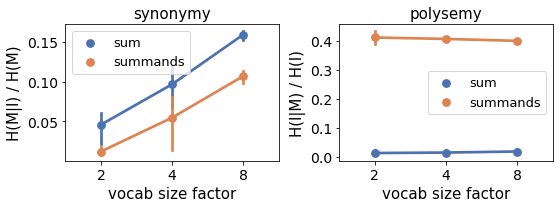

In [60]:
plt.figure(figsize=(8, 3))

for i in range(2): 
    plt.subplot(1, 2, i+1)
    metric = ['H(m|input)', 'H(input|m)']  
    ax = sns.pointplot(x='factor', hue='input_type', y=metric[i], data=mappings[mappings.factor>1], palette='deep')
    plt.title(['synonymy', 'polysemy'][i], fontsize=15)
    plt.ylabel(['H(M|I) / H(M)', 'H(I|M) / H(I)'][i], fontsize=15)
    plt.xlabel('vocab size factor', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(labels=['sum', 'summands'])
    l = plt.legend(fontsize=13, title='input')
    l.set_title(None)

plt.tight_layout()

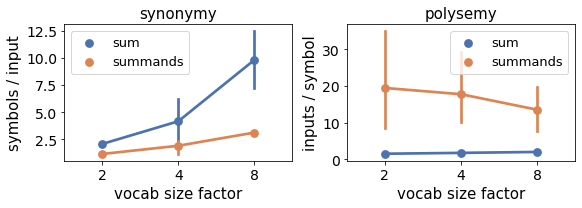

In [61]:
plt.figure(figsize=(8, 3))

for i in range(2): 
    plt.subplot(1, 2, i+1)
    metric = ['synonymy_mean', 'polysemy_mean']  
    ax = sns.pointplot(x='factor', hue='input_type', y=metric[i], data=mappings[mappings.factor>1], palette='deep')
    plt.title(['synonymy', 'polysemy'][i], fontsize=15)
    plt.ylabel(['symbols / input', 'inputs / symbol'][i], fontsize=15)
    plt.xlabel('vocab size factor', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(labels=['sum', 'summands'])
    l = plt.legend(fontsize=13, title='input')
    l.set_title(None)

plt.tight_layout()

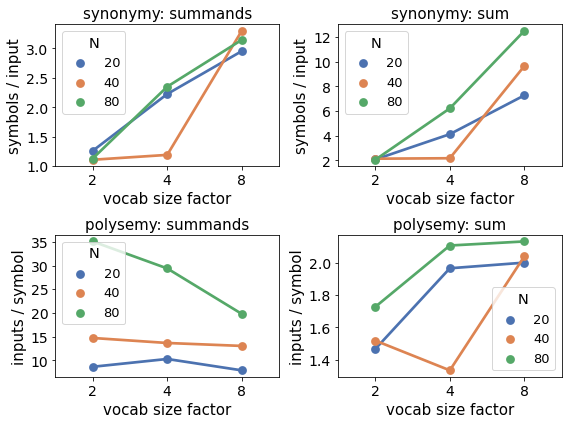

In [14]:
plt.figure(figsize=(8, 6))

for i in range(4): 
    plt.subplot(2, 2, i+1)
    metric = ['synonymy_mean', 'synonymy_mean', 'polysemy_mean', 'polysemy_mean'][i]
    input_type = ['summands', 'sum', 'summands', 'sum']
    sns.pointplot(x='factor', hue='N', y=metric, 
                  data=mappings[(mappings.input_type==input_type[i]) & (mappings.factor > 1)], 
                  palette='deep')
    plt.title(['synonymy', 'synonymy', 'polysemy', 'polysemy'][i] +': ' + input_type[i] , fontsize=15)
    plt.ylabel(['symbols / input', 'symbols / input', 'inputs / symbol', 'inputs / symbol'][i], fontsize=15)
    plt.xlabel('vocab size factor', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    l = plt.legend(fontsize=13, title='N')
    l.get_title().set_fontsize(fontsize='x-large')
    
plt.tight_layout()

In [45]:
N_collection = [20, 40, 80]
V_factors = [1, 2, 4, 8]

mappings2 = {'N': [], '|V|': [], 'factor': [], 'input_type': [], 'metric': [], 'value': []}

for N in N_collection:
    print('loading results for N: ', N)
    
    min_V = 2*N + 1
    
    for factor in V_factors:
        
        V = min_V * factor
        
        logs = load_interaction(N, V, mode='train')
        numbers = one_hot_to_numbers(logs.sender_input)
        sums = torch.sum(numbers, dim=1)
        messages = logs.message.argmax(dim=-1)
        
        _, symbols_per_summands, _ = synonymy_dict(numbers, messages)
        _, symbols_per_sum, _ = synonymy_dict(sums, messages)
        _, summands_per_symbol, _ = polysemy_dict(numbers, messages)
        _, sums_per_symbol, _ = polysemy_dict(sums, messages)
        information_metrics = information_scores(logs)
        
        for i, input_type in enumerate(['sum', 'summands']):
            
            for metric in ['symbols/input', 'inputs/symbol', 'H(M|I)', 'H(I|M)', 'NMI']:
            
                mappings['N'].append(N)
                mappings['|V|'].append(V)
                mappings['factor'].append(factor)
                mappings['input_type'].append(input_type)
                mappings['metric'].append(metric)
                
                if metric == 'symbols/input':
                    mappings['value'].append([symbols_per_summands, symbols_per_sum][i])
                elif metric == 'inputs/symbol':
                    mappings['value'].append([summands_per_symbol, sums_per_symbol][i])
                elif metric == 'H(M|I)': 
                    mappings['value'].append(information_metrics['synonymy_' + input_type])
                elif metric == 'H(I|M)': 
                    mappings['value'].append(information_metrics['polysemy_' + input_type])
                else: 
                    mappings['value'].append(information_metrics['NMI_' + input_type])

mappings2 = pd.DataFrame(mappings2)

loading results for N:  20


C:\Users\Xenia\AppData\Local\Temp/ipykernel_26032/2569674125.py:30: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mappings['N'].append(N)


TypeError: cannot concatenate object of type '<class 'int'>'; only Series and DataFrame objs are valid

<AxesSubplot:xlabel='factor', ylabel='value'>

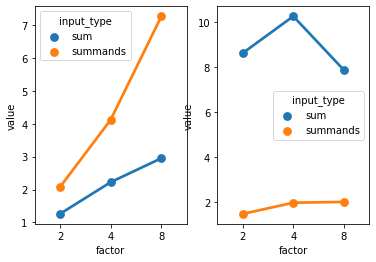

In [34]:
plt.subplot(1,2,1)
sns.pointplot(x='factor', y='value', hue='input_type', 
            data=mappings[(mappings.N==20) &
                          (mappings.factor > 1) &
                          (mappings.metric == 'symbols/input')])

plt.subplot(1,2,2)
sns.pointplot(x='factor', y='value', hue='input_type', 
              data=mappings[(mappings.N==20) &
                          (mappings.factor > 1) &
                          (mappings.metric == 'inputs/symbol')])